# Project Gutenberg Pipeline

**Input one Gutenberg ebook page URL to: extract metadata → fetch & clean the text → identify narrative boundaries with AI → save the core literary text.**

In [1]:
import os
import re
from urllib import request
from helper import (
    setup_openai,
    fetch_metadata,
    save_metadata,
    plaintext_url,
    locate_anchor,
    normalise,
)
from gutenberg_cleaner import simple_cleaner
import nltk
from nltk import word_tokenize

# Initialise OpenAI client
client = setup_openai()
print("OpenAI client successfully initialised!")

user_input = input("Enter the Gutenberg ebook ID: ")
gutenberg_url = f"https://www.gutenberg.org/ebooks/{user_input}"


OpenAI client successfully initialised!


---
## 1 · Metadata

Scrape the ebook page and persist a JSON sidecar in `metadata/`.

In [2]:
# Fetch all available metadata from the Gutenberg ebook page
meta = fetch_metadata(gutenberg_url)

if meta.get("error"):
    print(f"Warning: {meta['error']}")

for key, value in meta.items():
    print(f"{key:20s}: {value}")

title               : Frankenstein; Or, The Modern Prometheus
author              : Shelley, Mary Wollstonecraft
language            : English
publication_date    : 1818
ebook_no            : 42324
subjects            : ['Science fiction', 'Horror tales', 'Gothic fiction', 'Scientists -- Fiction', 'Monsters -- Fiction', 'Frankenstein, Victor (Fictitious character) -- Fiction', "Frankenstein's monster (Fictitious character) -- Fiction"]
genre               : Science fiction
source_url          : https://www.gutenberg.org/ebooks/42324


In [3]:
# Save metadata to metadata/<ebook_id>.metadata.json
saved_path = save_metadata(meta, output_dir="metadata")
print(f"Metadata saved → {saved_path}")

Metadata saved → metadata\42324.metadata.json


---
## 2 · Fetch text & preliminary cleanup

The plain-text URL is derived automatically from the ebook ID. `gutenberg_cleaner` strips the standard Gutenberg header/footer boilerplate, then we take a 50 000-character `head` and `tail` slice to feed to the LLM — keeping token usage bounded.

In [4]:
# Derive plain-text URL from ebook ID and fetch
ebook_id = meta["ebook_no"]
url = plaintext_url(ebook_id)
print(f"Fetching: {url}")

response = request.urlopen(url)
raw = response.read().decode("utf-8-sig")

# Strip Gutenberg boilerplate — use START/END markers first, fall back to simple_cleaner
_start_pat = re.compile(r"\*{3}\s*START OF THE PROJECT GUTENBERG[^\n]*\*{3}", re.IGNORECASE)
_end_pat   = re.compile(r"\*{3}\s*END OF THE PROJECT GUTENBERG[^\n]*\*{3}", re.IGNORECASE)

_start_m = _start_pat.search(raw)
_end_m   = _end_pat.search(raw)

if _start_m and _end_m and _end_m.start() > _start_m.end():
    # Reliable path: slice between the two markers
    cleaned_text = raw[_start_m.end() : _end_m.start()].strip()
    print("Cleaned via START/END markers.")
else:
    # Fallback for files without standard markers
    cleaned_text = simple_cleaner(raw)
    print("Cleaned via simple_cleaner (no standard markers found).")

# Slice head and tail for LLM boundary detection
head = cleaned_text[:50000]
tail = cleaned_text[-50000:]

print(f"\nTotal cleaned characters: {len(cleaned_text):,}")
print(f"\n--- HEAD PREVIEW (first 1000 chars) ---\n{head[:1000]}")

Fetching: https://www.gutenberg.org/cache/epub/42324/pg42324.txt
Cleaned via START/END markers.

Total cleaned characters: 445,757

--- HEAD PREVIEW (first 1000 chars) ---
FRANKENSTEIN:

                                  OR,

                         THE MODERN PROMETHEUS.

                          BY MARY W. SHELLEY.

            AUTHOR OF THE LAST MAN, PERKIN WARBECK, &c. &c.

    [Transcriber's Note: This text was produced from a photo-reprint of
    the 1831 edition.]


    REVISED, CORRECTED,
    AND ILLUSTRATED WITH A NEW INTRODUCTION,
    BY THE AUTHOR.

    LONDON:
    HENRY COLBURN AND RICHARD BENTLEY,
    NEW BURLINGTON STREET:
    BELL AND BRADFUTE, EDINBURGH;
    AND CUMMING, DUBLIN.
    1831.




INTRODUCTION.


The Publishers of the Standard Novels, in selecting "Frankenstein" for
one of their series, expressed a wish that I should furnish them with
some account of the origin of the story. I am the more willing to
comply, because I shall thus give a general answer to the

In [5]:
print(f"--- TAIL PREVIEW (last 1000 chars) ---\n{tail[-1000:]}")

--- TAIL PREVIEW (last 1000 chars) ---
remorse will not cease to rankle in my
wounds until death shall close them for ever.

"But soon," he cried, with sad and solemn enthusiasm, "I shall die, and
what I now feel be no longer felt. Soon these burning miseries will be
extinct. I shall ascend my funeral pile triumphantly, and exult in the
agony of the torturing flames. The light of that conflagration will fade
away; my ashes will be swept into the sea by the winds. My spirit will
sleep in peace; or if it thinks, it will not surely think thus.
Farewell."

He sprung from the cabin-window, as he said this, upon the ice-raft
which lay close to the vessel. He was soon borne away by the waves, and
lost in darkness and distance.


THE END.


    LONDON:
    Printed by A. & R Spottiswoode,
    New-Street-Square.

    [Transcriber's Note: Possible printer errors corrected:
    Line 2863: "I do no not fear to die" to "I do now not fear to die"
    Line 6375: "fulfil the wishes of you parents" to "

---
## 3 · Identify narrative boundaries with AI

Six chained LLM calls form two symmetric pipelines (start and end), each following the same **Map → Select → Extract** pattern:

In [6]:
# -- Call 1: Start Mapper
# Decompose the opening of the text into labelled segments
start_mapper_prompt = f"""
<task_objective>
Decompose the text into **Structural Segments**.
Map the transition from front matter to the literary narrative.
</task_objective>

<segment_classification_rules>
- **EDITORIAL**: content not originating from the author (metadata, forewords, copyright information, transcriber notes, contents pages, prolegomenon, frontispiece, publisher information).
- **AUTHORIAL**: content originating from the author (main narrative, chapters, poems, prologues, prefaces, epigraphs, introductions, half title).
- **AUTHORIAL (ISLAND)**: Very short authorial fragments immediately followed by EDITORIAL segments.
</segment_classification_rules>

<mapping_instructions>
1. Analyze the text.
2. List every distinct heading or section as a numbered segment.
3. If a "Sandwich" (Authorial -> Editorial -> Authorial) occurs, precisely delineate the breaks.
</mapping_instructions>

<output_format>
Return a numbered list only, for example:
1. [Segment Name] (EDITORIAL)
2. [Segment Name] (AUTHORIAL - ISLAND)
3. [Segment Name] (EDITORIAL)
4. [Segment Name] (AUTHORIAL)
</output_format>

TEXT:
{head[:50000]}
"""

response = client.responses.create(model="gpt-5-mini", input=start_mapper_prompt)
start_segments = response.output_text
print(f"Start Segment Analysis:\n{start_segments}")

Start Segment Analysis:
1. FRANKENSTEIN: / OR, / THE MODERN PROMETHEUS. / BY MARY W. SHELLEY. / AUTHOR OF THE LAST MAN, PERKIN WARBECK, &c. &c. (EDITORIAL)
2. [Transcriber's Note: This text was produced from a photo-reprint of the 1831 edition.] (EDITORIAL)
3. REVISED, CORRECTED, AND ILLUSTRATED WITH A NEW INTRODUCTION, BY THE AUTHOR. (EDITORIAL)
4. LONDON: HENRY COLBURN AND RICHARD BENTLEY, NEW BURLINGTON STREET: BELL AND BRADFUTE, EDINBURGH; AND CUMMING, DUBLIN. 1831. (EDITORIAL)
5. INTRODUCTION. (AUTHORIAL)
6. M. W. S. / _London, October 15, 1831._ (AUTHORIAL)
7. PREFACE. (AUTHORIAL)
8. FRANKENSTEIN; OR, THE MODERN PROMETHEUS. (main-title heading preceding the narrative) (AUTHORIAL)
9. LETTER I. (AUTHORIAL)
10. To Mrs. Saville, England. (LETTER I salutation) (AUTHORIAL)
11. St. Petersburgh, Dec. 11th, 17--. (LETTER I dateline) (AUTHORIAL)
12. LETTER II. (AUTHORIAL)
13. To Mrs. Saville, England. (LETTER II salutation) (AUTHORIAL)
14. Archangel, 28th March, 17--. (LETTER II dateline) 

In [7]:
# -- Call 2: Start Selector
# Pick the single segment where the main narrative begins
start_selector_prompt = f"""
<task>
Select the "Narrative Anchor": the specific segment where the main literary work begins.
</task>

<input_analysis>
{start_segments}
</input_analysis>

<selection_logic>
1. **Continuity Test:** Locate the LAST (EDITORIAL) segment. The (AUTHORIAL) segment immediately following it is the primary candidate.
2. **Island Bypass:** If an (AUTHORIAL - ISLAND) appears early but is separated from the main body by more EDITORIAL text, skip it.
3. **The Mainland Rule:** Select the segment that initiates the final, unbroken sequence of (AUTHORIAL) content.
</selection_logic>

<priority_ranking>
- Priority 1: First Chapter/Book heading after the final editorial interruption.
- Priority 2: Authorial Preface leading directly into narrative segments.
- Priority 3: First Authorial segment (if no Editorial segments exist).
</priority_ranking>

<output_rule>
Return ONLY the exact name of the segment. Return 'NULL' if no narrative start is found.
</output_rule>
"""

response = client.responses.create(model="gpt-5-nano", input=start_selector_prompt)
start_segment = response.output_text.strip()
print(f"Target Start Segment:\n{start_segment}")

Target Start Segment:
FRANKENSTEIN; OR, THE MODERN PROMETHEUS.


In [8]:
# -- Call 3: Start Extractor
# Pull verbatim opening lines of the target segment to use as an anchor string
start_extractor_prompt = f"""
<task>
Extract the exact literal starting string for the segment: '{start_segment}'.
</task>

<extraction_rules>
- **Zero-Tolerance for Hallucination**: Do not summarise or fix typos; precision and accuracy are key.
- **Starting Point**: Begin from the first character of the segment's title/heading.
- **Length**: Provide exactly the first 5 lines of the text from this segment.
- **Precision**: Maintain all original whitespace, capitalisation, and line breaks.
</extraction_rules>

<uniqueness_verification>
Ensure the extracted snippet is unique. If '{start_segment}' appears in a Table of Contents (EDITORIAL), ignore it and find the version that starts the actual (AUTHORIAL) text block.
</uniqueness_verification>

<output_restriction>
Return ONLY the raw text. No labels. No preamble.
</output_restriction>

TEXT:
{head[:15000]}
"""

response = client.responses.create(model="gpt-5-mini", input=start_extractor_prompt)
start_anchor = response.output_text.strip()
print(f"Start Anchor:\n{start_anchor}")

Start Anchor:
FRANKENSTEIN:

                                  OR,

                         THE MODERN PROMETHEUS.


In [9]:
# -- Call 4: End Mapper
# Decompose the closing of the text into labelled segments
end_mapper_prompt = f"""
<task_objective>
Decompose the text into **Structural Segments**.
Map the transition from the literary narrative to the back matter.
Identify every distinct section in the final 25,000 characters.
</task_objective>

<segment_classification_rules>
- **AUTHORIAL**: content originating from the author (main narrative, afterwords, epilogues, authorial postscripts, authorial appendices).
- **AUTHORIAL (ISLAND)**: Short authorial fragments (e.g., "The End") that are followed by EDITORIAL text.
- **EDITORIAL**: content not originating from the author (non-authorial appendices, glossaries, index, endnotes, acknowledgments, transcriber notes, metadata).
</segment_classification_rules>

<output_format>
Return a numbered list of the final segments:
1. [Segment Name] (AUTHORIAL)
2. [Segment Name] (AUTHORIAL - ISLAND)
3. [Segment Name] (EDITORIAL)
</output_format>

TEXT:
{tail[-25000:]}
"""

response = client.responses.create(model="gpt-5-mini", input=end_mapper_prompt)
end_segments = response.output_text
print(f"End Segment Analysis:\n{end_segments}")

End Segment Analysis:
1. Frankenstein's closing reflections/conversation with Walton (final speech about Clerval, Elizabeth, pursuit, and death) (AUTHORIAL)
2. Asterism divider and shift to Walton's correspondence (lead-in) (AUTHORIAL)
3. Walton — Letter dated September 2d ("My beloved Sister," — peril on the ice, concerns for Margaret, description of the guest) (AUTHORIAL)
4. Walton — Letter dated September 5th (mutiny deputation, Frankenstein's rousing speech to the sailors) (AUTHORIAL)
5. Walton — Letter dated September 7th (consent to return; loss of hopes) (AUTHORIAL)
6. Walton — Letter dated September 12th (return voyage narrative, Frankenstein's last hours and speech to Walton, Frankenstein's death, the creature's arrival, its long self-reproach/monologue, and its departure) (AUTHORIAL)
7. "THE END." (short authorial finality marker) (AUTHORIAL - ISLAND)
8. Printer imprint / publication metadata ("LONDON: Printed by A. & R Spottiswoode, New-Street-Square.") (EDITORIAL)
9. Transc

In [10]:
# -- Call 5: End Selector
# Identify the last segment that belongs to the author
end_selector_prompt = f"""
<task>
Based on the segment analysis, identify the **Exit Anchor**: the specific segment where the narrative officially concludes.
</task>

<input_analysis>
{end_segments}
</input_analysis>

<selection_logic>
1. **The Exit Test:** Identify the LAST segment labeled (AUTHORIAL) or (AUTHORIAL - ISLAND) that occurs before the final block of (EDITORIAL) text begins.
2. **Postscript Rule:** If a segment is an "Epilogue" or "Author's Note," it should be included as the exit anchor unless it is separated from the story by a significant EDITORIAL block.
3. **The Finality Rule:** We want the very last bit of text that came from the author's pen.
</selection_logic>

<output_rule>
Return ONLY the exact name of the segment. No extra text.
</output_rule>
"""

response = client.responses.create(model="gpt-5-nano", input=end_selector_prompt)
end_segment = response.output_text.strip()
print(f"Target End Segment:\n{end_segment}")

Target End Segment:
"THE END." (short authorial finality marker) (AUTHORIAL - ISLAND)


In [11]:
# -- Call 6: End Extractor
# Pull verbatim closing lines of the exit segment to use as an anchor string
end_extractor_prompt = f"""
<task>
Extract the exact literal CLOSING string for the segment: '{end_segment}'.
</task>

<extraction_rules>
- **Zero-Tolerance for Hallucination**: Return only what is present in the TEXT.
- **Precision**: You are looking for the LAST 5 lines of the '{end_segment}' section.
- **Verbatim**: Maintain all original whitespace, capitalisation, and punctuation.
- **Constraint**: Do NOT include any text from the EDITORIAL segments that follow it.
</extraction_rules>

<output_restriction>
Return ONLY the raw text. No labels. No preamble.
</output_restriction>

TEXT:
{tail[-25000:]}
"""

response = client.responses.create(model="gpt-5-mini", input=end_extractor_prompt)
end_anchor = response.output_text.strip()
print(f"End Anchor:\n{end_anchor}")

End Anchor:
He was soon borne away by the waves, and
lost in darkness and distance.


THE END.


---
## 4 · Extract & save core text

Locate the two anchor strings in the cleaned text, slice out everything between them, and write it to `core_txts/<ebook_id>_clean.txt`.

In [12]:
# Locate both anchor strings in the cleaned text
start_idx, start_len = locate_anchor(cleaned_text, start_anchor, is_start=True)
end_idx,   end_len   = locate_anchor(cleaned_text, end_anchor,   is_start=False)

print(f"Start: index={start_idx}, length={start_len}")
print(f"End:   index={end_idx},   length={end_len}")
print()
print(f"Normalised start: {repr(normalise(start_anchor)[:80])}")
print(f"Normalised end:   {repr(normalise(end_anchor)[-80:])}")

if start_idx != -1 and end_idx != -1:
    text_core = cleaned_text[start_idx : end_idx + end_len]
    print(f"\nExtraction successful — {len(text_core):,} characters")
    print(f"\nSTART → {repr(text_core[:80])}")
    print(f"END   → {repr(text_core[-80:])}")
else:
    raise RuntimeError(
        f"Anchor matching failed — start_idx={start_idx}, end_idx={end_idx}.\n"
        "Re-run the LLM calls or inspect the anchor strings above."
    )

Start: index=0, length=101
End:   index=445466,   length=8

Normalised start: 'FRANKENSTEIN:\n\n OR,\n\n THE MODERN PROMETHEUS.'
Normalised end:   'e was soon borne away by the waves, and\nlost in darkness and distance.\n\nTHE END.'

Extraction successful — 445,474 characters

START → 'FRANKENSTEIN:\r\n\r\n                                  OR,\r\n\r\n                      '
END   → ' soon borne away by the waves, and\r\nlost in darkness and distance.\r\n\r\n\r\nTHE END.'


In [13]:
# Save core text to core_txts/<ebook_id>_clean.txt
output_dir = "core_txts"
os.makedirs(output_dir, exist_ok=True)

file_path = os.path.join(output_dir, f"{ebook_id}_clean.txt")
with open(file_path, "w", encoding="utf-8") as f:
    f.write(text_core)

print(f"Core text saved → {file_path}")

Core text saved → core_txts\42324_clean.txt


---
## 5 · NLTK demo

A quick demonstration of NLTK's text-analysis tools on `text_core`.

In [14]:
nltk.download("punkt_tab", quiet=True)

# Tokenise core text into a word list
tokens = word_tokenize(text_core)

In [15]:
type(tokens)

list

In [16]:
len(tokens)

90568

In [17]:
tokens[:15]

['FRANKENSTEIN',
 ':',
 'OR',
 ',',
 'THE',
 'MODERN',
 'PROMETHEUS',
 '.',
 'BY',
 'MARY',
 'W.',
 'SHELLEY',
 '.',
 'AUTHOR',
 'OF']

In [18]:
# Wrap tokens in NLTK Text for corpus-level analysis
nltk_text = nltk.Text(tokens)

In [19]:
# Frequently co-occurring word pairs
nltk_text.collocations()

old man; Mr. Kirwin; natural philosophy; native country; Mont Blanc;
taken place; Cornelius Agrippa; mean time; looked upon; dear Victor;
Lord Byron; Mrs. Saville; _To Mrs.; young man; poor girl; take place;
many months; next morning; two months; several hours


In [20]:
# Contextual occurrences of a word — change to any word in the text
nltk_text.concordance("said")

Displaying 25 of 105 matches:
e will each write a ghost story , '' said Lord Byron ; and his proposition was
t of what the Doctor really did , or said that he did , but , as more to my pu
w , I did not sleep , nor could I be said to think . My imagination , unbidden
When I appeared on deck , the master said , `` Here is our captain , and he wi
ore I come on board your vessel , '' said he , `` will you have the kindness t
ter , when he was alone with me , he said , -- '' I have , doubtless , excited
 wreck so attractive and amiable . I said in one of my letters , my dear Marga
d can not begin life anew . '' As he said this , his countenance became expres
 19 . 17 -- . Yesterday the stranger said to me , `` You may easily perceive ,
g brought to my home , my mother had said playfully , -- '' I have a pretty pr
ly at the titlepage of my book , and said , `` Ah ! Cornelius Agrippa ! My dea
nd unsatisfied . Sir Isaac Newton is said to have avowed that he felt like a c
 and astonishing to me

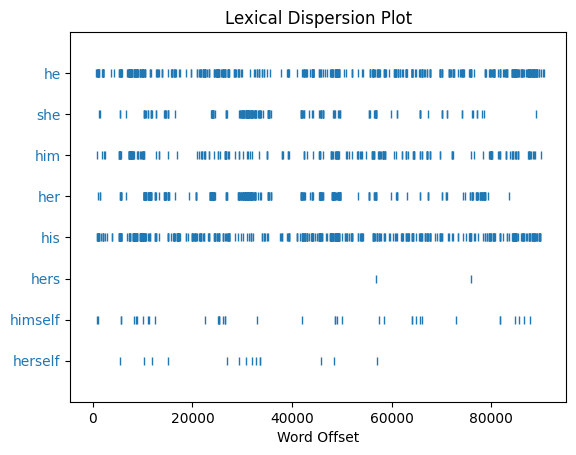

In [ ]:
# Distribution of key words across the text — edit list to suit the book
nltk_text.dispersion_plot(["he", "she", "him", "her", "his", "hers"])